# Modelo LSTM

## Lectura de datos

In [3]:
import pandas as pd
import nltk
import gensim

df = pd.read_pickle("./dataset/final.pkl")

#### Total de palabras en el Dataset

In [4]:
list_of_words = []
unique_words = set()
for document in df.clean:
    for word in document:
        list_of_words.append(word)
        unique_words.add(word)
        
total_words = len(list_of_words)  # total words
unique_words = len(unique_words)   # total unique words
print("Total words:" + str(total_words) + " unique_words:" + str(unique_words))

Total words:8844981 unique_words:96148


## Partición del dataset

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

In [7]:
xv_train[0]

<1x87349 sparse matrix of type '<class 'numpy.float64'>'
	with 187 stored elements in Compressed Sparse Row format>

In [8]:
from nltk import word_tokenize
from keras.preprocessing import text,sequence
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)
# train_sequences = tokenizer.texts_to_sequences(x_train)
# X_test = sequence.pad_sequences(train_sequences, maxlen=300)
# X_test[0]

In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
# Sequential Model
model = Sequential()

# embeddidng layer
model.add(Embedding(total_words, output_dim = 128))
# model.add(Embedding(total_words, output_dim = 240))

 
# Bi-Directional RNN and LSTM
model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1132157568
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,132,453,761
Trainable params: 1,132,453,761
Non-trainable params: 0
_________________________________________________________________


In [11]:
from tensorflow.python.client import device_lib 
import tensorflow as tf
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12132530205585418116
]
Num GPUs Available:  0


In [12]:
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 
total_words

8844981

In [13]:
import numpy as np
y_train = np.asarray(y_train)

model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 [==============================] - 4168s 8s/step - loss: 0.0443 - acc: 0.9825 - val_loss: 0.0072 - val_acc: 0.9981
Epoch 2/2
506/506 [==============================] - 4157s 8s/step - loss: 0.0026 - acc: 0.9994 - val_loss: 0.0056 - val_acc: 0.9983


## Evaluación

In [14]:
prediction = model.predict(padded_test)

In [15]:
prediction_list = []
for i in range(len(prediction)):
    if prediction[i].item() > 0.5:
        prediction_list.append(1)
    else:
        prediction_list.append(0)

In [17]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(list(y_test), prediction_list)

print("Model Accuracy : ", accuracy)

Model Accuracy :  0.9976614699331848


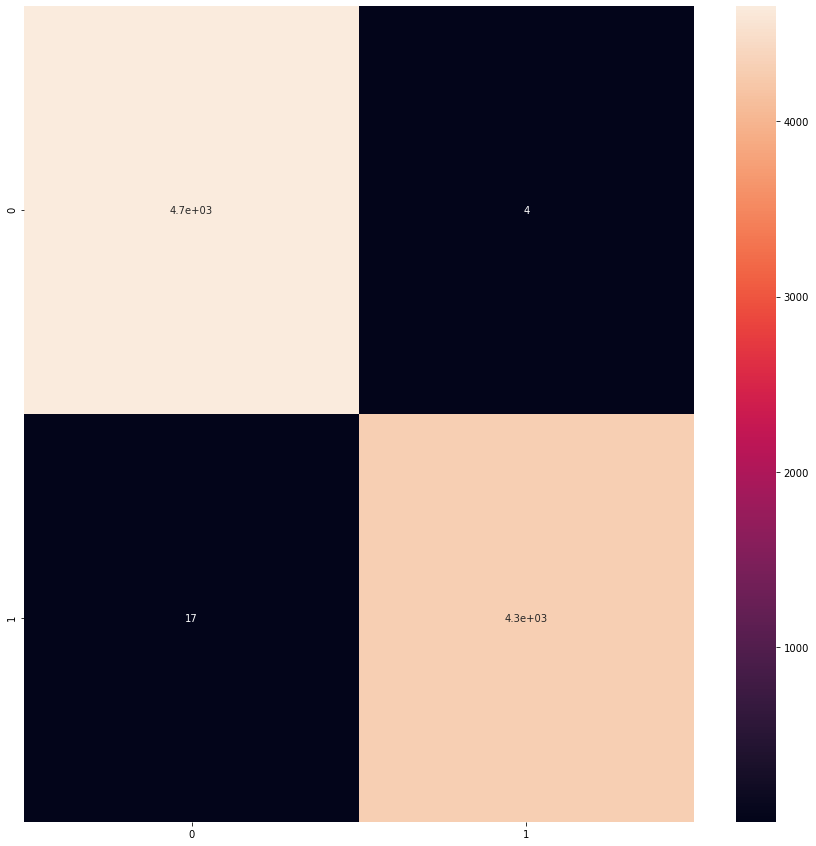

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(list(y_test), prediction_list)
plt.figure(figsize = (15, 15))
sns.heatmap(cm, annot = True)
plt.show()



ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Matriz de confusión'); 
ax.xaxis.set_ticklabels(['business', 'health']); ax.yaxis.set_ticklabels(['health', 'business']);

[Text(0, 0.5, 'Reales'), Text(0, 1.5, 'Falsas')]

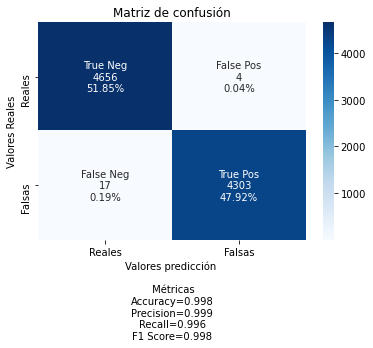

In [50]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(list(y_test), prediction_list)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

precision = cm[1,1] / sum(cm[:,1])
recall    = cm[1,1] / sum(cm[1,:])
f1_score  = 2*precision*recall / (precision + recall)
stats_text = "\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)

ax= plt.subplot()
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax = ax); #annot=True to annotate cells

ax.set_xlabel('Predicted label' + stats_text)

# labels, title and ticks
ax.set_xlabel("Valores predicción \n\n Métricas" + stats_text)
ax.set_ylabel('Valores Reales')
ax.set_title('Matriz de confusión')
ax.xaxis.set_ticklabels(['Reales', 'Falsas'])
ax.yaxis.set_ticklabels(['Reales', 'Falsas'])